# Importando bibliotecas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Lendo dados

In [3]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [4]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [5]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [6]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [7]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [9]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,  
        eval_metric='logloss'
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\Leonardo\Python\PROJETOS FACULDADE\clean_project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:04:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


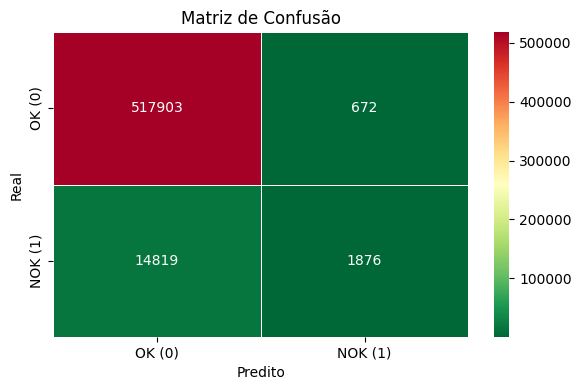

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [11]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df.head(3)

,precision,recall,f1-score,support
0,0.972182,0.998704,0.985265,518575.000000
1,0.736264,0.112369,0.194980,16695.000000
accuracy,0.971059,0.971059,0.971059,0.971059


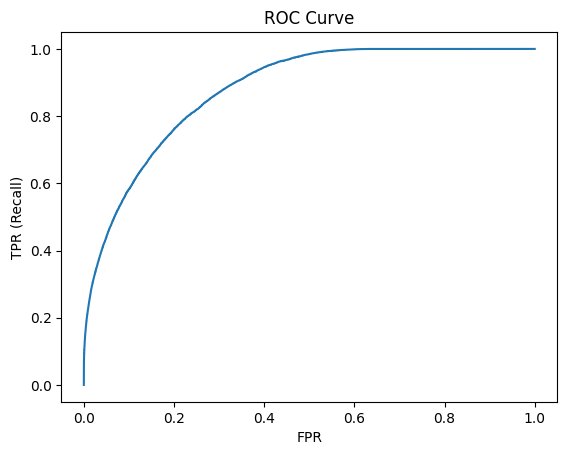

AUC: 0.88


In [12]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")

